In [ ]:
from functools import reduce

In [2]:
import gmm

In [3]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [4]:
from combinators import lens, sampler, tracing
from combinators.model import collections
from discopy import PRO, Ty

In [5]:
D = 2
K = 3
N = 5
NUM_SAMPLES = 1

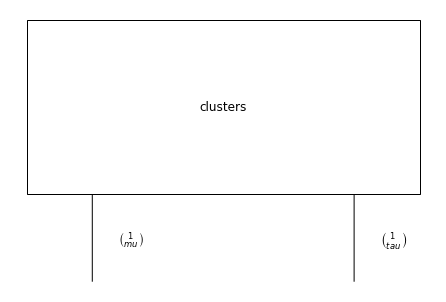

In [6]:
clusters = sampler.ImportanceSampler(gmm.GaussianClusters(K, D), None, (NUM_SAMPLES,))
clusters_prior = tracing.TracedLensBox('clusters', lens.LensPRO(0), PRO(2) & Ty('mu', 'tau'), clusters, clusters.update)
clusters_prior.draw()

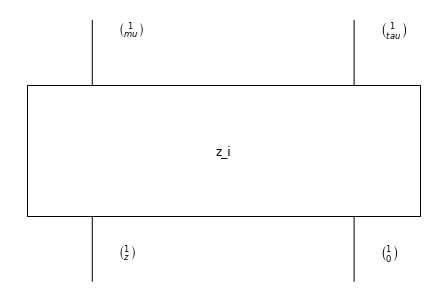

In [7]:
z_sampler = sampler.ImportanceSampler(gmm.SampleCluster(K), None, (NUM_SAMPLES,))
cluster_latent = tracing.TracedLensBox('z_i', PRO(2) & Ty('mu', 'tau'), PRO(2) & Ty('z'), z_sampler, z_sampler.update)
cluster_latent.draw()

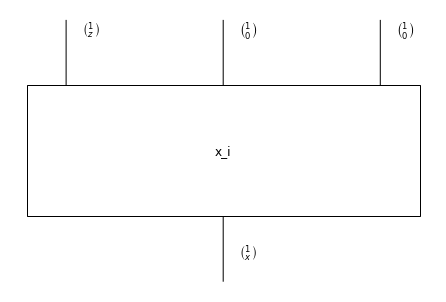

In [8]:
x_sampler = sampler.ImportanceSampler(gmm.SamplePoint(), None, (NUM_SAMPLES,))
observe_point = tracing.TracedLensBox('x_i', PRO(3) & Ty('z'), PRO(1) & Ty('x'), x_sampler, x_sampler.update)
observe_point.draw()

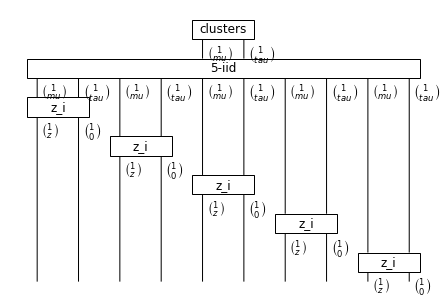

In [9]:
priors = clusters_prior >> collections.iid(clusters_prior.cod, N, cluster_latent)
priors.draw()

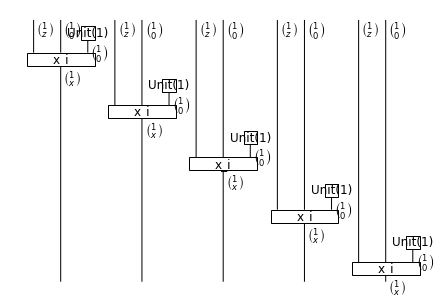

In [10]:
nones = [lens.Unit(None, PRO(1) & PRO(0)) for _ in range(N)]
unconditioned_xs = [lens.Id(PRO(2) & Ty('z')) @ none >> observe_point for none in nones]
likelihood = reduce(lambda f, g: f @ g, unconditioned_xs, lens.Id(lens.LensPRO(0)))
likelihood.draw()

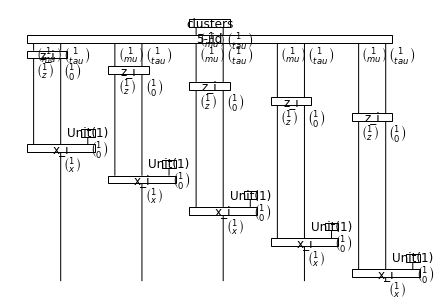

In [11]:
model = priors >> likelihood
model.draw()

In [12]:
model()

((tensor([[[ 6.6534, -0.2804]]]),
  tensor([[[-0.7744, -1.3931]]]),
  tensor([[[0.7499, 1.9449]]]),
  tensor([[[-0.0404, -1.9320]]]),
  tensor([[[-0.2326,  0.4282]]])),
 <class 'combinators.tracing.TraceDiagram'>.ARROW([<class 'combinators.tracing.TraceDiagram'>.BOX(((tensor([[-0.3025, -0.9148],
         [ 0.4588, -0.1383],
         [-0.4455, -0.9611]]), tensor([[0.5268, 1.1331],
         [2.9681, 2.8805],
         [0.6182, 1.2178]])), tensor([0.]), Trace{'mu': Normal([torch.FloatTensor of size 3x2]), 'tau': Gamma([torch.FloatTensor of size 3x2])}, 'clusters_sample')), <class 'combinators.tracing.TraceDiagram'>.BOX(((tensor([[-0.3025, -0.9148],
         [ 0.4588, -0.1383],
         [-0.4455, -0.9611]]), tensor([[0.5268, 1.1331],
         [2.9681, 2.8805],
         [0.6182, 1.2178]]), tensor([[-0.3025, -0.9148],
         [ 0.4588, -0.1383],
         [-0.4455, -0.9611]]), tensor([[0.5268, 1.1331],
         [2.9681, 2.8805],
         [0.6182, 1.2178]]), tensor([[-0.3025, -0.9148],
       